# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 07.06.2024**

**Мягкий дедлайн: 23.06.2024 23:59 MSK**

**Жёсткий дедлайн: 23.06.2024 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


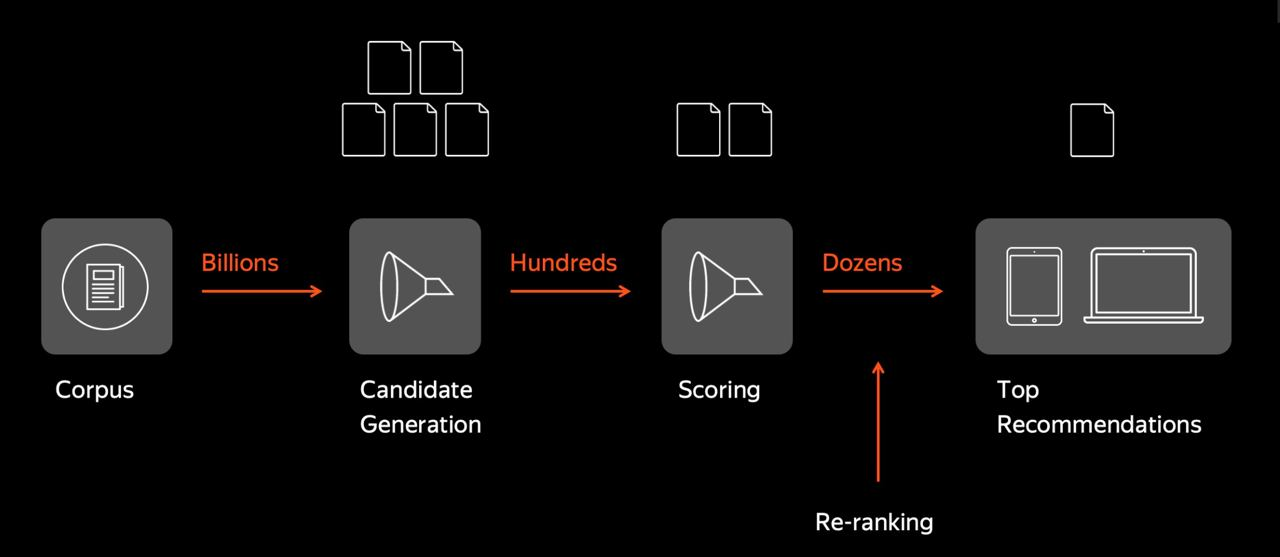

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [42]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [43]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [44]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [45]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    def apk(relevant_u, predicted_u, k):
        if len(predicted_u) > k:
            predicted_u = predicted_u[:k]
    
        score = 0.0
        num_hits = 0.0
        
        for i, p in enumerate(predicted_u):
            if p in relevant_u and p not in predicted_u[:i]:
                num_hits += 1.0
                score += num_hits / (i + 1.0)
        
        if not relevant_u:
            return 0.0
        
        return score / min(len(relevant_u), k)


    return np.mean([apk(r, p, k) for r, p in zip(relevant, predicted)])

In [46]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [47]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [48]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [49]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [50]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [51]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [52]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [53]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [54]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [55]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for u in range(self.n_users):
            test_preds += [self.recommend(u)]
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [56]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    intersection = (ratings * user_vector).sum(axis = 1)
    unity = (user_vector.sum() + ratings.sum(axis = 1)) - intersection 
    return intersection / unity

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [57]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        s = self.similarity(self.R[uid])
        neighs_idx = np.where(s > self.alpha)[0]#Вспомнил такую прикольную штуку как np.where
        neighs_idx = neighs_idx[neighs_idx != uid]
        return np.argsort(-1 * (s[neighs_idx] @ self.R[neighs_idx]))

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [58]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
u2u_jaccard = User2User(train_ratings)

k = 30
u2u_jaccard_pred = u2u_jaccard.get_test_recommendations(k)
random = np.random.choice(np.unique(ratings['trackId']), size=(len(test_users), k))
popular = np.array([np.argsort(-1 * u2u_jaccard.R.sum(axis = 0))[:k] for u in test_users])

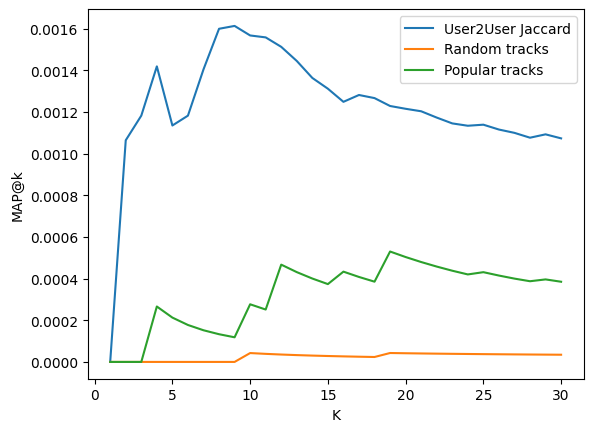

In [59]:
ks = np.arange(1, k + 1) # ks = [1, 2, ..., k]

mapk_u2u_jaccard = [mapk(test_relevant, u2u_jaccard_pred, k) for k in ks] #Предсказания
mapk_random = [mapk(test_relevant, random, k) for k in ks]
mapk_popular = [mapk(test_relevant, popular, k) for k in ks]

plt.plot(ks, mapk_u2u_jaccard, label='User2User Jaccard')
plt.plot(ks, mapk_random, label='Random tracks')
plt.plot(ks, mapk_popular, label='Popular tracks')

plt.xlabel('K')
plt.ylabel('MAP@k')
plt.legend()
plt.show()


**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [69]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
#уезжаю на сборы, поэтому не успел

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [61]:
model = User2User(train_ratings)
user_id = np.random.randint(0, model.n_users)


In [62]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
27,La Camisa Negra,['Juanes']
124,Pleasure To Kill,['Kreator']
805,Zombie,['The Cranberries']
827,Six Days,"['DJ Shadow', 'Mos Def']"
1019,It's My Life,['Bon Jovi']
1150,Apple Of Sodom,['Marilyn Manson']
1228,The Lost Song,['The Cat Empire']
1444,Karmacoma,['Massive Attack']
1570,Ace Of Spades,['Motörhead']
3199,The End,['The Doors']


In [63]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
6231,Yeah!,"['Usher', 'Lil Jon', 'Ludacris']"
54280,Комета,['JONY']
33436,Believer,['Imagine Dragons']
49577,Кукла колдуна,['Король и Шут']
28807,Рапапам,"['9 грамм', 'Miyagi & Эндшпиль']"
59229,Мальчик на девятке,['DEAD BLONDE']
54220,Roses,['SAINt JHN']
18070,Dernière danse,['Indila']
18459,Take Me To Church,['Hozier']


In [64]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
63174,gorit,['DOROFEEVA']
63246,#туДЫМ-сюДЫМ,['Артур Пирожков']
63882,Scary Garry,"['Kaito Shoma', 'DJ Paul', 'Kingpin Skinny Pimp']"
64087,Beggin',"['Dame Dame', 'Lunis']"
64479,ТЫ ГОРИШЬ КАК ОГОНЬ,['SLAVA MARLOW']
64611,Призрак,['Коста Лакоста']
64640,Silence,['Sibewest']
64999,Ракета,['HARU']
65019,GAZ,['Kaito Shoma']
65609,От Винта!,['Смешарики']


В целом, есть несколько похожих треков и исполнителей... Но всё ещё как будто не супер.

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

Градиенты
$$
grad_p = 2 \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})*q_i  + 2\lambda \|p_u\|
​$$
$$
grad_q = 2 \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})*p_i  + 2\lambda \|q_u\|
​$$
Новый шаг для ri
$$
p_u = p_u - \eta \; ((p_u^Tq_i - r_{ui}) \cdot q_i + \lambda p_u)
$$ 
$$
q_i = q_i - \eta \; ((q_i^Tp_u - r_{ui}) \cdot p_u + \lambda q_i)
$$
​


Дифференцируем потери
$$
d_P [L] = 2 \cdot tr((R - P^T Q)^T(-d[P^T] Q]) + 2 \cdot tr(\lambda P^T d[P]) = tr(2((P^TQ - R)Q^T + \lambda P^T)d[P])
$$

Отсюда получаем градиент:

$$
grad(L)_p = 2 \cdot (Q(P^TQ - R)^T + \lambda P)
$$

$$
2(Q(P^TQ - R)^T + \lambda P) = 0
$$

$$
P = (\lambda I + QQ^T)^{-1}QR^T
$$

$$ 
Q = (\lambda I + PP^T)^{-1}PR
$$

**SGD:**
$$
p_u = p_u - \eta \; ((p_u^Tq_i - r_{ui}) \cdot q_i + \lambda p_u)
$$ 
$$
q_i = q_i - \eta \; ((q_i^Tp_u - r_{ui}) \cdot p_u + \lambda q_i)
$$
**ALS:**
$$
P = (\lambda I + QQ^T)^{-1}QR^T
$$

$$ 
Q = (\lambda I + PP^T)^{-1}PR
$$

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [65]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                item_idx = np.random.randint(0, self.n_items)
                user_idx = np.random.randint(0, self.n_users)

                # Латентные векторы для текущего пользователя и объекта
                q_i = self.Q[item_idx, :]
                p_u = self.P[user_idx, :]

                # Предсказанная оценка
                predicted_rating = p_u @ q_i

                # Истинная оценка
                true_rating = self.R[user_idx, item_idx]

                # Обновление латентных векторов по формулам
                self.Q[item_idx, :] -= self.lr * ((predicted_rating - true_rating) * p_u + self.lamb * q_i)
                self.P[user_idx, :] -= self.lr * ((predicted_rating - true_rating) * q_i + self.lamb * p_u)
            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                self.P = (np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.dim)) @ self.Q.T @ self.R.T).T #Тупо по формулам
                self.Q = (np.linalg.inv(self.P.T @ self.P + self.lamb * np.eye(self.dim)) @ self.P.T @ self.R).T

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [66]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
dim_grid = np.arange(32, 257, 32)
k_grid = np.arange(1, 51)
num_iters_grid = np.arange(5, 206, 20)

gs_res = {}

for opt_method in ['sgd']:
    gs_res[opt_method] = []  # Для каждого значения num_iters
    for num_iters in tqdm(num_iters_grid, desc='Num iters'):
        best_result = {'map': 0}
        for dim in tqdm(dim_grid, desc='Dimensions', leave=False):
            lfm = LatentFactorModel(train_ratings, dim, opt_method)
            lfm.fit(num_iters)
            predictions = lfm.get_test_recommendations(50)
            for k in k_grid:
                current_map = mapk(test_relevant, predictions, k)
                if current_map > best_result['map']:
                    best_result = {
                        'map': current_map,
                        'k': k,
                        'dim': dim
                    }
        gs_res[opt_method].append(best_result)

Num iters:   0%|          | 0/11 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

In [68]:
for opt_method in ['als']:
    gs_res[opt_method] = []  # Для каждого значения num_iters
    for num_iters in tqdm(num_iters_grid, desc='Num iters'):
        best_result = {'map': 0}
        for dim in tqdm(dim_grid, desc='Dimensions', leave=False): #Чтобы понятно было скока ждать
            lfm = LatentFactorModel(train_ratings, dim, opt_method)
            lfm.fit(num_iters)
            predictions = lfm.get_test_recommendations(50)
            for k in k_grid:
                current_map = mapk(test_relevant, predictions, k)
                if current_map > best_result['map']:
                    best_result = {
                        'map': current_map,
                        'k': k,
                        'dim': dim
                    }
        gs_res[opt_method].append(best_result)

Num iters:   0%|          | 0/11 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [70]:
# Преобразование результатов в DataFrame
sgd_df = pd.DataFrame(gs_res['sgd'])
als_df = pd.DataFrame(gs_res['als'])

# лучший sgd
best_sgd = sgd_df.loc[sgd_df['map'].idxmax()]
print('Best SGD:')
print(best_sgd)
print()

# лучший ALS
best_als = als_df.loc[als_df['map'].idxmax()]
print('Best ALS:')
print(best_als)

Best SGD:
map      0.008511
k        1.000000
dim    128.000000
Name: 8, dtype: float64

Best ALS:
map     0.008511
k       1.000000
dim    96.000000
Name: 0, dtype: float64


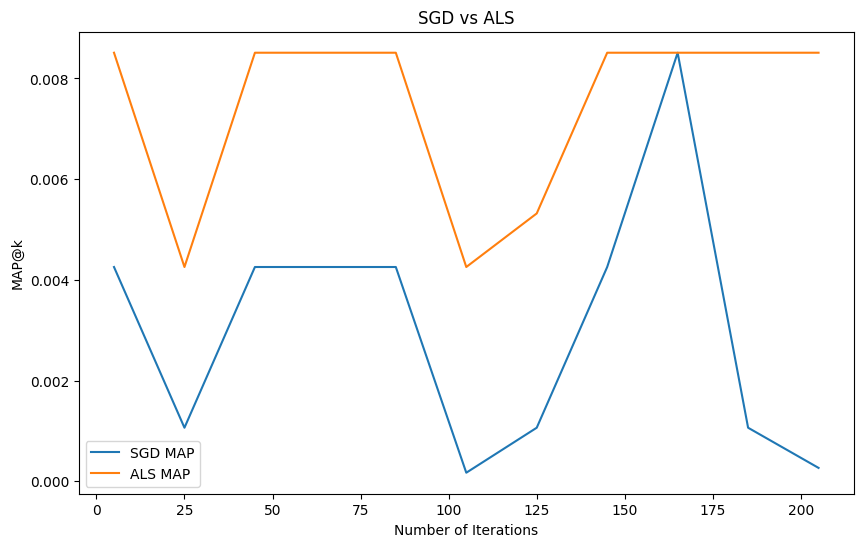

In [71]:
# графика
plt.figure(figsize=(10, 6))
plt.plot(num_iters_grid, sgd_df['map'], label='SGD MAP')
plt.plot(num_iters_grid, als_df['map'], label='ALS MAP')
plt.xlabel('Number of Iterations')
plt.ylabel('MAP@k')
plt.title('SGD vs ALS')
plt.legend()
plt.show()

In [72]:
model = LatentFactorModel(train_ratings, 96, 'als')
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [73]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
60908,POPSTAR,"['DJ Khaled', 'Drake']",0.440613
14444,4 AM,['Scooter'],0.431168
33635,White Horse,"['Croatia Squad', 'FREY', 'OMR']",0.411674
64183,Take Me Back,['DJ JEDY'],0.403301
50293,Ты небо,['Миша Марвин'],0.368120
10652,Beautiful Girl,['INXS'],0.367746
21935,Дорога,['Ворон Кутха'],0.365103
1789,Closer Every Day,['Secret Service'],0.361852
48776,Разрывай танцпол,['Мохито'],0.361546


эм нууууууууууууууу, хз вроде +- норм

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [74]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [75]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
lfm = LatentFactorModel(train_ratings, 96, 'als')
lfm.fit(25)
lfm_preds = lfm.get_test_recommendations(100)
u2u = User2User(train_ratings)
u2u_preds= u2u.get_test_recommendations(100)


  0%|          | 0/25 [00:00<?, ?it/s]

In [78]:
u2u_preds.shape

(235, 100)

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [76]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
train_objects = train_ratings.copy()
#Косинусное расстояние
user_embeddings = lfm.P[train_objects['userId']]
track_embeddings = lfm.Q[train_objects['trackId']]
numerator = (user_embeddings * track_embeddings).sum(axis=1)
denominator = np.linalg.norm(user_embeddings, axis=1, ord=2) * np.linalg.norm(track_embeddings, axis=1, ord=2)
train_objects['cos_dist'] = numerator / denominator


In [80]:
#кол-во треков
train_objects['tracks_listened'] = train_objects['userId'].value_counts()[train_objects['userId']].index

In [81]:
last50tracks = []
for user_id, user_vector in train_ratings.groupby('userId'):
    last50tracks.append(user_vector['trackId'][:50])
last50tracks = np.array(last50tracks)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id)
test_pool = catboost.Pool(X_test, y_test, group_id=test_group_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪